In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

## Low level functions
Including: 
- dprod  - for large matrices need Sparse?
- Chebyshev nodes  - different from the numpy version as both endpoints and Lobatto nodes are included
- Monomial and Chebyshev basis matrix
- Monomial and Chebyshev difference operator

Need:
- Splines
- High level extension for multidimensional basis matrices and Chebnodes - easy

In [2]:
@jit
def dprod(A,B):
    nobsa,na= A.shape
    nobsb,nb= B.shape
    Res= np.empty((nobsa,nb*na))
    if (nobsa!=nobsb):
        return 'A and B must have same number of rows'
    for t in range(nobsa):
        for ia in range(na):
            for ib in range(nb):            
                Res[t,nb*(ia-1)+ib]=A[t,ia] * B[t, ib]
    return Res

In [3]:
@jit
def Chebnodes(p, nodetype=0): # Cheb nodes- 1d
    n, a, b = p[0], p[1], p[2]
    s = (b-a) / 2 
    m = (b+a) / 2  
    if (nodetype < 2):  # usual nodes
        k = np.pi*np.linspace(0.5,n-0.5,n)  
        x = m - np.cos(k[0:n]/n) * s  
        if (nodetype == 1):  # Extend nodes to endpoints
            aa = x[0]  
            bb = x[-1]  
            x = (bb*a - aa*b)/(bb-aa) + (b-a)/(bb-aa)*x
    else: # Lobatto nodes
        k = np.pi*np.linspace(0,n-1,n)
        x = m - np.cos(k[0:n]/(n-1)) * s
    return x

In [4]:
@jit
def Chebbasex(p, x): # Cheb basis matrix - 1d
    n, a, b = p[0], p[1], p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    bas[:, 1] = z[:]
    z = 2 * z
    for i in range(m):
        for j in range(2,n):
            bas[i, j] = z[i] * bas[i, j-1] - bas[i, j-2]
    return bas

In [5]:
@jit
def Monobasex(p, x):  # Monomials basis matrix- 1d
    n, a, b = p[0], p[1], p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    for i in range(m):
        for j in range(1,n):
            bas[i, j] = z[i] * bas[i, j-1]
    return bas

In [6]:
@jit
def ChebDiffMatrix(p):  
    n, a, b = p[0], p[1], p[2]  #Differentiating matrix for Chebyshev polynomials
    D= np.zeros((n,n))
    for j in range(n):
        for i in range(int((n-j)/2)):
            D[j,j+1+2*i]=4*((2*i+j+1))/(b-a)
    D[0,:] = D[0,:]/2
    return D

In [7]:
@jit
def MonoDiffMatrix(p):  
    n, a, b = p[0], p[1], p[2]  #Differentiating matrix for mononomials - loops are faster then vectorizing
    D= np.zeros((n,n))
    for j in range(n-1):
        D[j,j+1]=(j+1)/(b-a)*2
    return D

## Test Functions
Examples for: 
- dprod for large matrices
- Approximating cos(x) and it's derivative using monomials and Chebyshev polynomial
- Approximate the multidimensional banana function and plot the approximation error

In [8]:
%%timeit
A1=np.random.randn(100,10)
B1=np.random.randn(100,1000)
C1=dprod(A1,B1)

The slowest run took 94.62 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 9.89 ms per loop


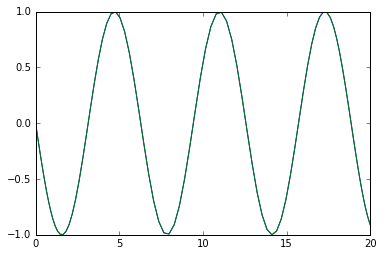

In [9]:
#Approximate cos(x) with Chebychev
n=20
x=Chebnodes((n,0,20),2)
y= np.cos(x)
Phi=Chebbasex((n,0,20),x)
#Invert to get polynomial coefficients
coeff= np.linalg.inv(Phi) @ y
D=ChebDiffMatrix((n,0,20))
x1=Chebnodes((100,0,20),0)
y1=np.cos(x1)
z1=-np.sin(x1)
Phi1=Chebbasex((n,0,20),x1)
y_approx= Phi1 @ coeff
z_approx= Phi1 @ D @ coeff
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

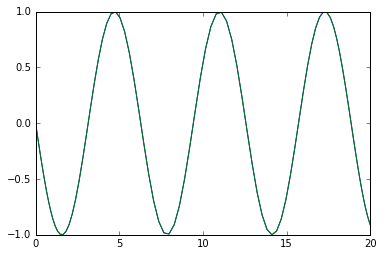

In [10]:
#Approximate cos(x) with monomial
n=20
x=Chebnodes((n,0,20),2)
y= np.cos(x)
Phi=Monobasex((n,0,20),x)
#Invert to get polynomial coefficients
coeff= np.linalg.inv(Phi) @ y
D=MonoDiffMatrix((n,0,20))
x1=Chebnodes((100,0,20),0)
y1=np.cos(x1)
z1=-np.sin(x1)
Phi1=Monobasex((n,0,20),x1)
y_approx= Phi1 @ coeff
z_approx= Phi1 @ D @ coeff
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

In [11]:
# Approximate the banana function - to be continued
n= 20
x=Chebnodes((n,-3,3),2)
s=np.concatenate([np.transpose(np.kron(x,np.ones((1,n)))),np.transpose(np.kron(np.ones((1,n)),x))],1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y=Banana(s)
Phi1=Chebbasex((n,-3,3), s[:,0])
Phi2=Chebbasex((n,-3,3), s[:,1])
Phi3=dprod(Phi1,Phi2)
coeff= np.linalg.inv(Phi3) @ y
#Generate the approximand
n1=100
x1=np.linspace(-3,3,n1)
s1=np.concatenate([np.transpose(np.kron(x1,np.ones((1,n1)))),np.transpose(np.kron(np.ones((1,n1)),x1))],1)
y1=Banana(s1)
Phi1a=Chebbasex((n,-3,3), s1[:,0])
Phi2a=Chebbasex((n,-3,3), s1[:,1])
Phi3a=dprod(Phi1a,Phi2a)
y_approx= Phi3a @ coeff


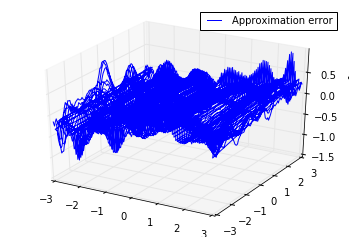

In [12]:
#3D Plot
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()